In [1]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

In [2]:
# General imports
import numpy as np
import os

# Plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

# ML imports
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
### Generate the data.
N = 10**6
mu = 0.1
sigma = 1

# Background is Normal(-μ, σ). Signal is Normal(μ, σ))
bkgd = np.random.normal(-mu, sigma, N)
sgnl = np.random.normal(mu, sigma, N)
X = np.concatenate([bkgd, sgnl])
y = np.concatenate([np.zeros(N), np.ones(N)])

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
# Loss functions
def bce(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * K.log(1. - y_pred))

def mse(y_true, y_pred):
    return -((y_true) * -K.square(1. - y_pred) + (1. - y_true) * -K.square(y_pred + K.epsilon()))

def mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred + K.epsilon()) + (1. - y_true) * (1. - y_pred))

def square_mlc(y_true, y_pred):
    return -((y_true) * K.log(y_pred**2) + (1. - y_true) * (1. - y_pred**2))

def exp_mlc(y_true, y_pred):
    return -((y_true) * y_pred + (1. - y_true) * (1. - K.exp(y_pred)))

def square_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.square(y_pred)) + (1. - y_true) * -K.sqrt(K.square(y_pred)))

def exp_sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(K.exp(y_pred)) + (1. - y_true) * -K.sqrt(K.exp(y_pred)))

def sqr(y_true, y_pred):
    return -((y_true) * -1. / K.sqrt(y_pred + K.epsilon()) + (1. - y_true) * -K.sqrt(y_pred + K.epsilon()))

def get_sqr(p):
    def sqr_p(y_true, y_pred):
        return -((y_true) * -K.pow(y_pred + K.epsilon(), -p/2) + (1. - y_true) * -K.pow(y_pred + K.epsilon(), p/2))
    return sqr_p
        
# Likelihood ratios
def lr(x):
    return np.exp(-(1/(2 * sigma**2)) * ( (x - mu)**2 - (x + mu)**2))

def odds_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f / (1. - f))
    return model_lr

def pure_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f)
    return model_lr

def square_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(f**2)
    return model_lr

def exp_lr(model):
    def model_lr(x):
        f = model.predict(x)
        return np.squeeze(np.exp(f))
    return model_lr

def make_mae(N_mae=10**4):
    mu = 0.1
    sigma = 1

    bkgd_mae = np.random.normal(-mu, sigma, N_mae)
    sgnl_mae = np.random.normal(mu, sigma, N_mae)
    X_mae = np.concatenate([bkgd_mae, sgnl_mae])
    
    def mae(model_lr):
        nonlocal X_mae
        return np.abs(model_lr(X_mae) - lr(X_mae)).mean()
    return mae
    
mae = make_mae()

In [5]:
earlystopping = EarlyStopping(patience=10,
                              verbose=0,
                              restore_best_weights=True)

In [6]:
# Models
def create_model(loss,
                 hidden='relu', 
                 output='sigmoid', 
                 dropout=True, 
                 optimizer='adam', 
                 metrics=['accuracy'], 
                 verbose=0):
    model = Sequential()
    if dropout:
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dropout(0.1))
        model.add(Dense(128, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(64, activation=hidden))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation=output))
    else: 
        model.add(Dense(64, activation=hidden, input_shape=(1, )))
        model.add(Dense(128, activation=hidden))
        model.add(Dense(64, activation=hidden))
        model.add(Dense(1, activation=output))        
    
    model.compile(loss=loss,
                  optimizer=optimizer, 
                  metrics=metrics)
    
    return model

def train(loss,
          hidden='relu', 
          output='sigmoid', 
          dropout=True, 
          optimizer='adam', 
          metrics=['accuracy'], 
          verbose=0):
    model = create_model(loss, hidden, output, dropout, optimizer, verbose)
    
    trace = model.fit(X_train, 
                      y_train,
                      epochs = 100, 
                      batch_size=int(0.1*N), 
                      validation_data=(X_test, y_test),
                      callbacks=[earlystopping], 
                      verbose=verbose)
    print(trace.history['val_loss'][-1], end = ' ')
    
    return model

In [43]:
# Plotting functions
def get_preds(model_lrs, xs=np.linspace(-6, 6, 1000)):
    # Takes in model_lrs, a list of model likelihood ratios and xs, a list of 
    # values on which to compute the likelihood ratios. Returns a 2D array. The 
    # nth row is the likelihood ratio predictions from the nth model in 
    # model_lrs.
    return np.array([model_lr(xs) for model_lr in model_lrs])
    
def avg_lr(preds):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average likelihood ratio prediction and its error.
    return preds.mean(axis=0), preds.std(axis=0)

def avg_lrr(preds, xs=np.linspace(-6, 6, 1000)):
    # Takes in a 2D array of multiple models' likelihood ratio predictions. 
    # Returns the average ratio of predicted likelihood to true likelihood and 
    # its error.
    lrr_preds = preds / lr(xs)
    return lrr_preds.mean(axis=0), lrr_preds.std(axis=0)
    
def lr_plot(ensembles,
            title=None,
            filename=None,
            cs = ['brown', 'green', 'red', 'blue'],
            lss = [':', '--', '-.', ':'],
            xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lr_avg, lr_err). Plots them against the true 
    # likelihood.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot true likelihood
    plt.plot(xs, lr(xs), label = 'Exact', c='k', ls='-')
    
    # Plot model likelihoods
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Likelihood Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(-6, 6)
    plt.xlabel(r'$x$')
    plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
    if title != None:
        plt.title(title, loc="left", fontsize=20)
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')

def lrr_plot(ensembles,
             title=None,
             filename=None,
             cs = ['brown', 'green', 'red', 'blue'],
             lss = [':', '--', '-.', ':'],
             xs=np.linspace(-6, 6, 1000)):
    # Takes in a list of pairs (lrr_avg, lrr_err). Plots them.
    fig, ax_1 = plt.subplots(figsize = (10, 6))
    
    # Plot ratios of likelihood ratios
    for i in range(len(ensembles)):
        avg, err, lbl = ensembles[i]
        plt.plot(xs, avg, label=lbl, c=cs[i], ls=lss[i])
        plt.fill_between(xs, avg - err, avg + err, color=cs[i], alpha=0.1)
    plt.axhline(1,ls=":",color="grey", lw=0.5)
    plt.axvline(0,ls=":",color="grey", lw=0.5)
    plt.legend()
    ax_1.minorticks_on()
    ax_1.tick_params(direction='in', which='both',length=5)
    plt.ylim(0.94, 1.06)
    plt.ylabel('Ratio')

    # Plot background and signal
    ax_2 = ax_1.twinx()
    bins = np.linspace(-6, 6, 100)
    plt.hist(sgnl, alpha=0.1, bins=bins)
    plt.hist(bkgd, alpha=0.1, bins=bins)
    ax_2.minorticks_on()
    ax_2.tick_params(direction='in', which='both',length=5)
    plt.ylabel('Count')

    plt.xlim(-6, 6)
    plt.xlabel(r'$x$')
    plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20)
    if title != None:
        plt.title(title, loc="left", fontsize=20)
    if filename != None:
        plt.savefig(filename, dpi=1200, bbox_inches='tight')

# MLC Activation Parametrizations

In [ ]:
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output':'relu'}
params_2 = {'loss':square_mlc, 'output':'linear'}
params_3 = {'loss':exp_mlc, 'output':'linear'}

filestr_1 = 'models/ratios/mlc/mlc_model_{}.h5'
filestr_2 = 'models/ratios/mlc/square_mlc_model_{}.h5'
filestr_3 = 'models/ratios/mlc/exp_mlc_model_{}.h5'

In [ ]:
# Train and save models
%%time

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

In [ ]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1).load_weights(filestr_1.format(i))
    model_2 = create_model(**params_2).load_weights(filestr_2.format(i))
    model_3 = create_model(**params_3).load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [ ]:
# Get average predictions and errors. Add on the labels for plotting.
lr_1 = avg_lr(get_preds(lrs_1)) + ('MLC (linear)',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('MLC (square)',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('MLC (exponential)',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('MLC (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('MLC (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('MLC (exponential)',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 'plots/mlc_act_param_lr.png')

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 'plots/mlc_act_param_lrr.png')

# SQR Activation Parametrizations

In [ ]:
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output':'relu'}
params_2 = {'loss':square_sqr, 'output':'linear'}
params_3 = {'loss':exp_sqr, 'output':'linear'}

filestr_1 = 'models/ratios/sqr/sqr_model_{}.h5'
filestr_2 = 'models/ratios/sqr/square_sqr_model_{}.h5'
filestr_3 = 'models/ratios/sqr/exp_sqr_model_{}.h5'

In [ ]:
# Train and save models
%%time

for i in range(reps):
    print(i, end = ' ')
    model_1 = train(**params_1)
    model_2 = train(**params_2)
    model_3 = train(**params_3)
    print()
    model_1.save_weights(filestr_1.format(i))
    model_2.save_weights(filestr_2.format(i))
    model_3.save_weights(filestr_3.format(i))

In [ ]:
# Get model likelihood ratios.
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps
for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1)
    lrs_2[i] = square_lr(model_2)
    lrs_3[i] = exp_lr(model_3)

In [ ]:
# Get average predictions and errors. Add on the labels to 
# make plotting easier.
lr_1 = avg_lr(get_preds(lrs_1)) + ('SQR (linear)',)
lr_2 = avg_lr(get_preds(lrs_2)) + ('SQR (square)',)
lr_3 = avg_lr(get_preds(lrs_3)) + ('SQR (exp)',)

lrr_1 = avg_lrr(get_preds(lrs_1)) + ('SQR (linear)',)
lrr_2 = avg_lrr(get_preds(lrs_2)) + ('SQR (square)',)
lrr_3 = avg_lrr(get_preds(lrs_3)) + ('SQR (exponential)',)

In [ ]:
lr_plot([lr_1, lr_2, lr_3], 'plots/sqr_act_param_lr.png')

In [ ]:
lrr_plot([lrr_1, lrr_2, lrr_3], 'plots/sqr_act_param_lrr.png')

# SQR Loss Parametrizations

In [8]:
reps = 10

ps = np.linspace(-2, 2, 100)
filestr = 'models/sqr/sqr_model_{}_{}.h5'

In [ ]:
# Train models
%%time

for p in ps:
    print('===================================================\n{}'.format(p))
    params = {'loss': get_sqr(p), 'output':'relu'}
    for i in range(10):
        print(i, end = ' ')
        model = train(**params)
        print()
        model.save_weights(filestr.format(p, i))

In [17]:
# Get model likelihood ratios.
lrs = {}
for p in ps:
    lrs[p] = [None] * reps
    params = {'loss': get_sqr(p), 'output':'relu'}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(filestr.format(p, i))
        lrs[p][i] = pure_lr(model)

0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6 7 8 9 
0 1 2 3 4 5 6

In [19]:
# Get average predictions and errors. Add on the labels to 
# make plotting easier.
lr_avgs = []
lrr_avgs = []
for p in ps:
    lr_avgs += [avg_lr(get_preds(lrs[p])) + ('{0:.{1}f}'.format(p, 3),)]
    lrr_avgs += [avg_lrr(get_preds(lrs[p])) + ('{0:.{1}f}'.format(p, 3),)]

Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000018763E5C4C8>
Traceback (most recent call last):
  File "C:\Users\septi\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'deleter'


IndexError: list index out of range

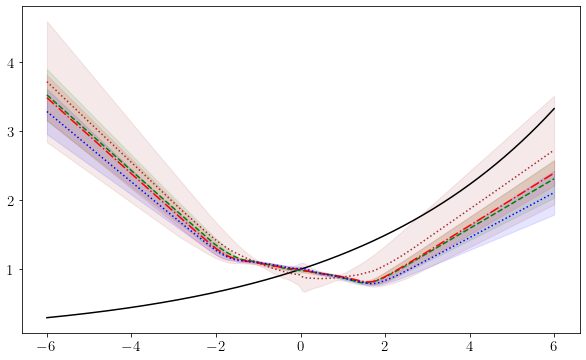

In [20]:
lr_plot(lr_avgs, 'plots/sqr_loss_param_lr.png')

IndexError: list index out of range

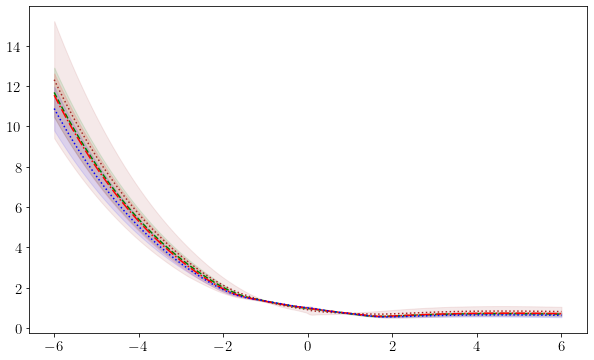

In [21]:
lrr_plot(lrr_avgs, 'plots/sqr_loss_param_lrr.png')

In [26]:
mae_avg = []
mae_err = []

for p in ps:
    maes = [mae(lr) for lr in lrs[p]]
    mae_avg += [np.mean(maes)]
    mae_err += [np.std(maes)]
    print(mae_avg[-1])

mae_avg = np.array(mae_avg)
mae_err = np.array(mae_err)

0.2687086883481553
0.2520796838317442
0.2453262012435748
0.25032389918661063
0.2536460658791072
0.2519961451708827
0.2649541264401388
0.2572003311272103
0.2634794334313332
0.263682266866626
0.26590726289346983
0.2639312655555789
0.27810492889403615
0.2699277962416999
0.27687032299640724
0.28189611078772087
0.28519630794845796
0.286683958860704
0.2915889762957501
0.2910841221799755
0.3022196487111458
0.30075091718490204
0.3070463528267554
0.3155076219257603
0.32089488649872944
0.3273040892913562
0.3333064731375177
0.34135421501986
0.3492511095555112
0.3569582742796131
0.3675363880650305
0.38560977300100374
0.3967504806111296
0.41019216096827493
0.4286527433959586
0.44600934095450206
0.4720186006716423
0.4991686245911769
0.5348273761656495
0.5722262276731002
0.621317514496494
0.6859833917101434
0.7802481572875798
0.8911482536393567
1.0594987813148398
1.3594479209031889
1.8916897829207464
2.9342303866093036
4.3744542049161526
4.01191610238662
5.360627533640725
4.896805200728549
2.60630248

NameError: name 'bce_mae_avg' is not defined

In [27]:
mae_avg = np.array(mae_avg)
mae_err = np.array(mae_err)

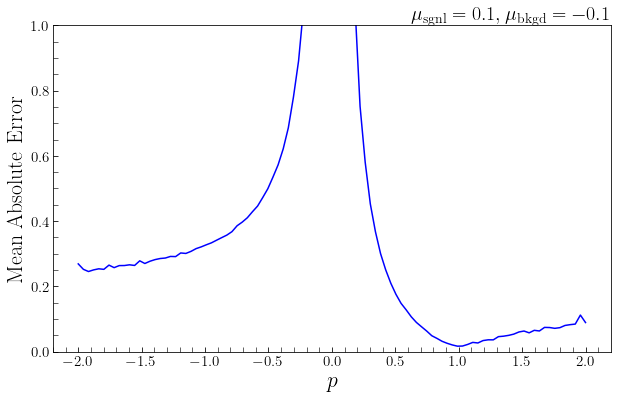

In [30]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(ps, mae_avg, c='blue')

plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylim(0, 1)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/sqr_loss_params_maes.png', dpi=1200, bbox_inches='tight')

# Scheme Comparisons

In [31]:
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':exp_mlc, 'hidden':'relu', 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}

bce_filestr = 'models/maes/bce/bce_model_{}_{}.h5'
mse_filestr = 'models/maes/mse/mse_model_{}_{}.h5'
mlc_filestr = 'models/maes/mlc/mlc_model_{}_{}.h5'
sqr_filestr = 'models/maes/sqr/sqr_model_{}_{}.h5'

In [ ]:
# Train models
%%time

bce_lrs = {}
mse_lrs = {}
mlc_lrs = {}
sqr_lrs = {}
for N in Ns:
    print('===================================================\n{}'.format(N))
    bce_lrs[N] = [None] * reps
    mse_lrs[N] = [None] * reps
    mlc_lrs[N] = [None] * reps
    sqr_lrs[N] = [None] * reps
    
    # Generate data
    bkgd = np.random.normal(-mu, 1, N)
    sgnl = np.random.normal(mu, 1, N)
    X = np.concatenate([bkgd, sgnl])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    for i in range(reps):
        print(i, end = ' ')
        bce_model = train(**bce_params)
        mse_model = train(**mse_params)
        mlc_model = train(**mlc_params)
        sqr_model = train(**sqr_params)
        print()
        bce_model.save_weights(bce_filestr.format(N, i))
        mse_model.save_weights(mse_filestr.format(N, i))
        mlc_model.save_weights(mlc_filestr.format(N, i))
        mlc_model.save_weights(sqr_filestr.format(N, i))

## Mean Absolute Error

In [34]:
# Calculate mean absolute errors
bce_mae_avg = []
mse_mae_avg = []
mlc_mae_avg = []
sqr_mae_avg = []

bce_mae_err = []
mse_mae_err = []
mlc_mae_err = []
sqr_mae_err = []

for N in Ns:
    print(N)
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, i))
        mse_lrs[i] = odds_lr(mse_model)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, i))
        mlc_lrs[i] = exp_lr(mlc_model)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, i))
        sqr_lrs[i] = exp_lr(sqr_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    mse_maes = [mae(lr) for lr in mse_lrs]
    mlc_maes = [mae(lr) for lr in mlc_lrs]
    sqr_maes = [mae(lr) for lr in sqr_lrs]
    
    bce_mae_avg += [np.mean(bce_maes)]
    bce_mae_err += [np.std(bce_maes)]
    
    mse_mae_avg += [np.mean(mse_maes)]
    mse_mae_err += [np.std(mse_maes)]
    
    mlc_mae_avg += [np.mean(mlc_maes)]
    mlc_mae_err += [np.std(mlc_maes)]
    
    sqr_mae_avg += [np.mean(sqr_maes)]
    sqr_mae_err += [np.std(sqr_maes)]

bce_mae_avg = np.array(bce_mae_avg)
mse_mae_avg = np.array(mse_mae_avg)
mlc_mae_avg = np.array(mlc_mae_avg)
sqr_mae_avg = np.array(sqr_mae_avg)

bce_mae_err = np.array(bce_mae_err)
mse_mae_err = np.array(mse_mae_err)
mlc_mae_err = np.array(mlc_mae_err)
sqr_mae_err = np.array(sqr_mae_err)

100
1000
10000
100000
1000000
10000000


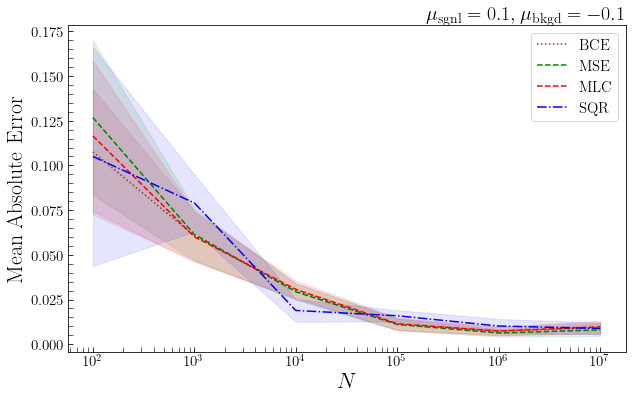

In [35]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(Ns, bce_mae_avg, c='brown', ls=':', label='BCE')
plt.plot(Ns, mse_mae_avg, c='green', ls='--', label='MSE')
plt.plot(Ns, mlc_mae_avg, c='red', ls='--', label='MLC')
plt.plot(Ns, sqr_mae_avg, c='blue', ls='-.', label='SQR')
plt.fill_between(Ns, bce_mae_avg - bce_mae_err, bce_mae_avg + bce_mae_err, color='brown', alpha=0.1)
plt.fill_between(Ns, mse_mae_avg - mse_mae_err, mse_mae_avg + mse_mae_err, color='green', alpha=0.1)
plt.fill_between(Ns, mlc_mae_avg - mlc_mae_err, mlc_mae_avg + mlc_mae_err, color='red', alpha=0.1)
plt.fill_between(Ns, sqr_mae_avg - sqr_mae_err, sqr_mae_avg + sqr_mae_err, color='blue', alpha=0.1)
plt.legend()

plt.xscale("log", base=10)
plt.minorticks_on()
plt.tick_params(direction='in', which='both',length=5)
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$N$')

plt.title(r"$\mu_{\rm{sgnl}}="+str(mu)+r", \mu_{\rm{bkgd}}="+str(-mu)+r"$",loc="right",fontsize=20);
plt.savefig('plots/updated_maes.png', dpi=1200, bbox_inches='tight')

## Likelihood Ratios

In [36]:
N = 10**6
reps = 100

In [37]:
# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = exp_lr(mlc_model)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = exp_lr(sqr_model)

In [38]:
bce_lr = avg_lr(get_preds(bce_lrs)) + ('BCE',)
mse_lr = avg_lr(get_preds(mse_lrs)) + ('MSE',)
mlc_lr = avg_lr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lr = avg_lr(get_preds(sqr_lrs)) + ('SQR',)

bce_lrr = avg_lrr(get_preds(bce_lrs)) + ('BCE',)
mse_lrr = avg_lrr(get_preds(mse_lrs)) + ('MSE',)
mlc_lrr = avg_lrr(get_preds(mlc_lrs)) + ('MLC',)
sqr_lrr = avg_lrr(get_preds(sqr_lrs)) + ('SQR',)

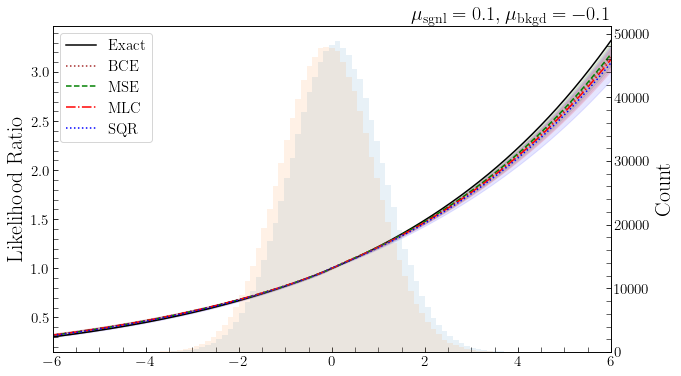

In [44]:
lr_plot([bce_lr, mse_lr, mlc_lr, sqr_lr], filename='plots/updated_lr_schemes.png')

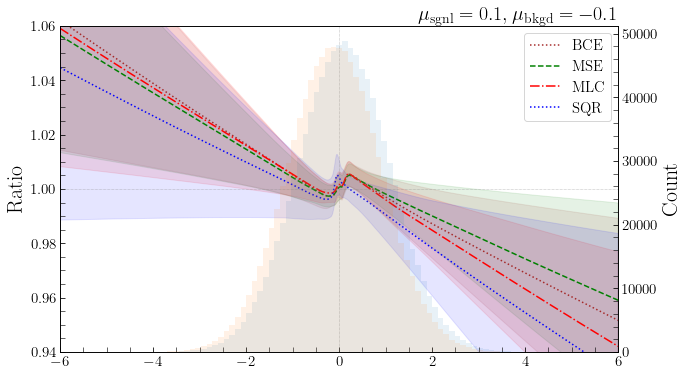

In [45]:
lrr_plot([bce_lrr, mse_lrr, mlc_lrr, sqr_lrr], filename='plots/updated_lrr_schemes.png')

In [41]:
bce_mae = np.mean([mae(lr) for lr in bce_lrs])
mse_mae = np.mean([mae(lr) for lr in mse_lrs])
mlc_mae = np.mean([mae(lr) for lr in mlc_lrs])
sqr_mae = np.mean([mae(lr) for lr in sqr_lrs])

In [42]:
print(bce_mae, mse_mae, mlc_mae, sqr_mae)

0.007441844983962329 0.006274675430339925 0.007358909876700646 0.010175778919035712
